In [1]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import moviepy.video.io.ImageSequenceClip
import plotly.graph_objects as go
from scipy.interpolate import splrep, splev
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# 1. Prosty przykład: y=sin(x)

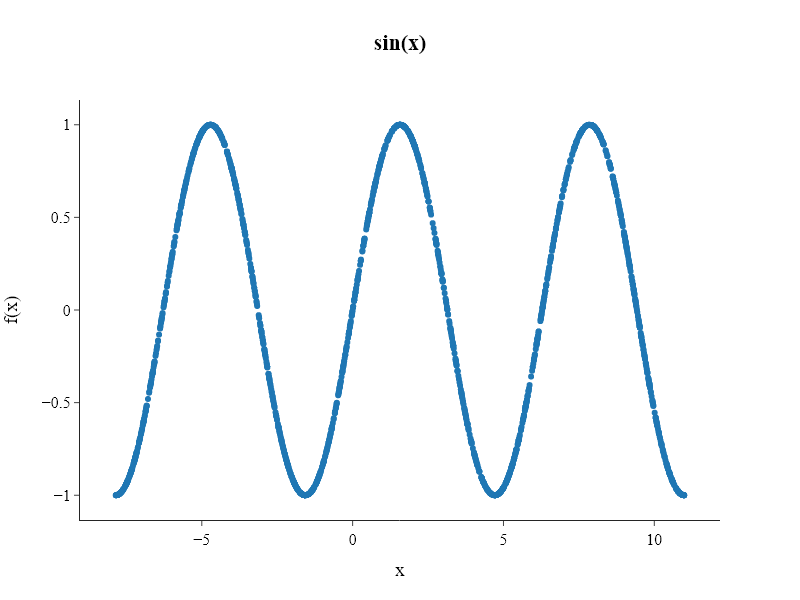

In [2]:
f = lambda x: torch.sin(x)
dataset = create_dataset(f, n_var=1, ranges=[-2.5*torch.pi, 3.5*torch.pi], train_num=2000, test_num=200)
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataset['train_input'][:,0], y=dataset['train_label'][:,0], mode='markers', name='train'))
fig.update_layout(template="simple_white", width=800, height=600, title="<b>sin(x)<b>", title_x=0.5, xaxis_title="x", yaxis_title="f(x)", font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

In [3]:
folder = "prezentacja"
degree = 1
Gs = [i for i in range(4, 31, 2)]
for G in Gs:
    grid = torch.linspace(-2.5*torch.pi, 3.5*torch.pi, G).reshape(-1, 1)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataset['train_input'][:,0], y=dataset['train_label'][:,0], mode='markers', name='data', marker=dict(color='black', size=10)))
    tck = splrep(grid.detach().numpy(), f(grid), k=degree)
    y_spline = splev(dataset['train_input'][:,0].numpy(), tck)
    fig.add_trace(go.Scatter(x=grid[:,0], y=f(grid)[:,0], mode='markers', name='Grid points', marker=dict(color='red', size=20)))
    fig.add_trace(go.Scatter(x=dataset['train_input'][:,0], y=y_spline, mode='markers', name='Spline'))
    fig.update_layout(template="simple_white", width=800, height=600, title_x=0.5, xaxis_title="x", yaxis_title="f(x)", font=dict(family="Times New Roman",size=16,color="Black"))
    fig.update_xaxes(range=[-2.5*torch.pi-0.5, 3.5*torch.pi+0.5])
    fig.update_yaxes(range=[-1.1, 1.1])
    # fig.show("png")
    #Save file to folder
    fig.write_image(f"{folder}/spline_{G}.png")
files = os.listdir(folder)
indices_of_files = [int(file.split("_")[1].split(".")[0]) for file in files if file.endswith(".png")]
indices_of_files.sort()
image_files = [f"{folder}/spline_{i}.png" for i in indices_of_files]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=2)
clip.write_videofile(f"{folder}/spline.mp4")

Moviepy - Building video prezentacja/spline.mp4.
Moviepy - Writing video prezentacja/spline.mp4



Moviepy - Done !
Moviepy - video ready prezentacja/spline.mp4


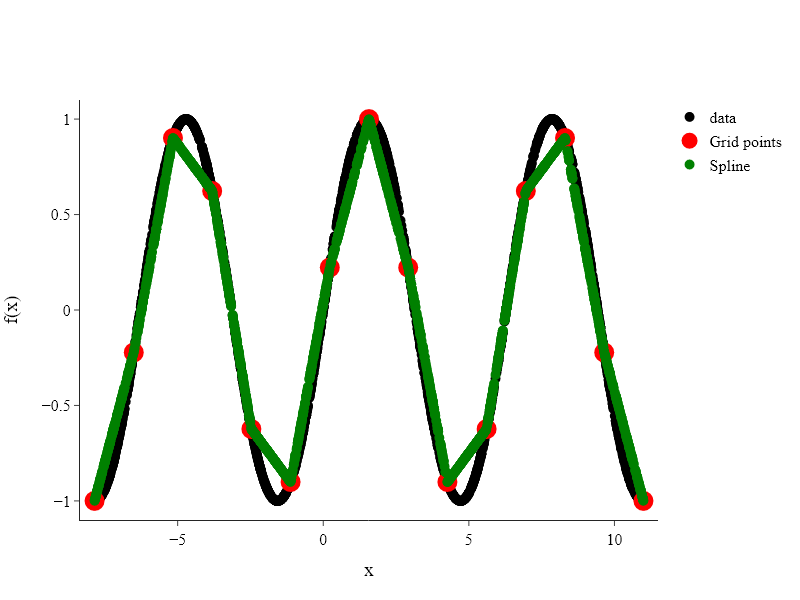

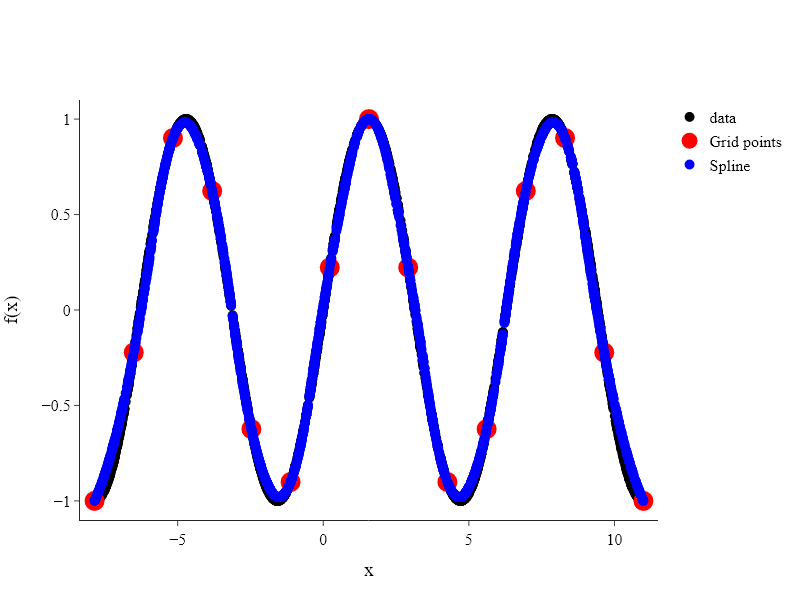

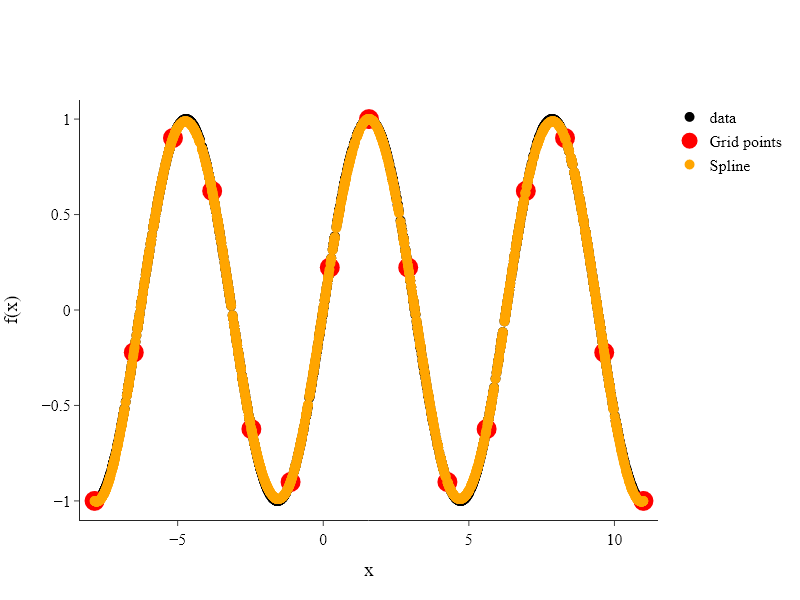

In [4]:
G = 15
grid = torch.linspace(-2.5*torch.pi, 3.5*torch.pi, G)
degrees = [1, 2, 3]
colors = ['green', 'blue', 'orange']
for i, degree in enumerate(degrees):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataset['train_input'][:,0], y=dataset['train_label'][:,0], mode='markers', name='data', marker=dict(color='black', size=10)))
    tck = splrep(grid.detach().numpy(), f(grid), k=degree)
    y_spline = splev(dataset['train_input'][:,0].numpy(), tck)
    fig.add_trace(go.Scatter(x=grid, y=f(grid), mode='markers', name='Grid points', marker=dict(color='red', size=20)))
    fig.add_trace(go.Scatter(x=dataset['train_input'][:,0], y=y_spline, mode='markers', name='Spline', marker=dict(color=colors[i], size=10)))
    fig.update_layout(template="simple_white", width=800, height=600, title_x=0.5, xaxis_title="x", yaxis_title="f(x)", font=dict(family="Times New Roman",size=16,color="Black"))
    fig.update_xaxes(range=[-2.5*torch.pi-0.5, 3.5*torch.pi+0.5])
    fig.update_yaxes(range=[-1.1, 1.1])
    fig.show("png")

train loss: 7.09e-03 | test loss: 7.78e-03 | reg: 1.77e+01 : 100%|██| 10/10 [00:04<00:00,  2.46it/s]


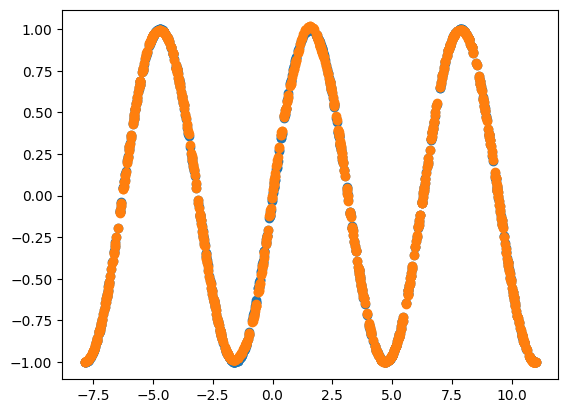

In [5]:
G = 15
k = 2
model = KAN(width=[1,15, 1], grid=G, k=k)
dataset = create_dataset(f, n_var=1, ranges=[-2.5*torch.pi, 3.5*torch.pi], train_num=1000, test_num=200)
model.train(dataset, opt="LBFGS", steps=10, update_grid=True)
output = model(dataset['train_input'])
plt.scatter(dataset['train_input'][:,0].numpy(), dataset['train_label'].numpy())
plt.scatter(dataset['train_input'][:,0].numpy(), output.detach().numpy())
plt.show()

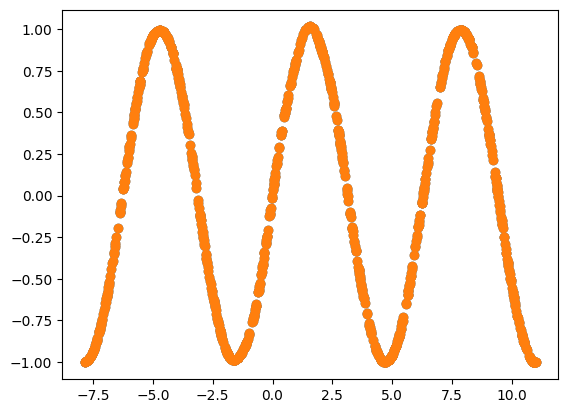

In [6]:
x = dataset['train_input']
for i in range(0, model.depth):
    x_transformed = torch.einsum('ij,k->ikj', x, torch.ones(model.act_fun[i].out_dim)).reshape(x.shape[0], model.act_fun[i].size).permute(1, 0)
    y = coef2curve(x_eval=x_transformed, grid=model.act_fun[i].grid, coef=model.act_fun[i].coef, k=k).permute(1, 0)
    base = model.base_fun(x_transformed).permute(1, 0)
    output_scratch = model.act_fun[i].scale_base*base + model.act_fun[i].scale_sp.unsqueeze(dim=0) * y
    output_scratch = torch.sum(output_scratch.reshape(x.shape[0], model.act_fun[i].out_dim, model.act_fun[i].in_dim), dim=2)
    x = output_scratch+model.biases[i].weight[0]
output_scratch = x
x = dataset['train_input']
plt.scatter(x[:,0].numpy(), output_scratch.detach().numpy())
plt.scatter(x[:,0].numpy(), output.detach().numpy())
plt.show()

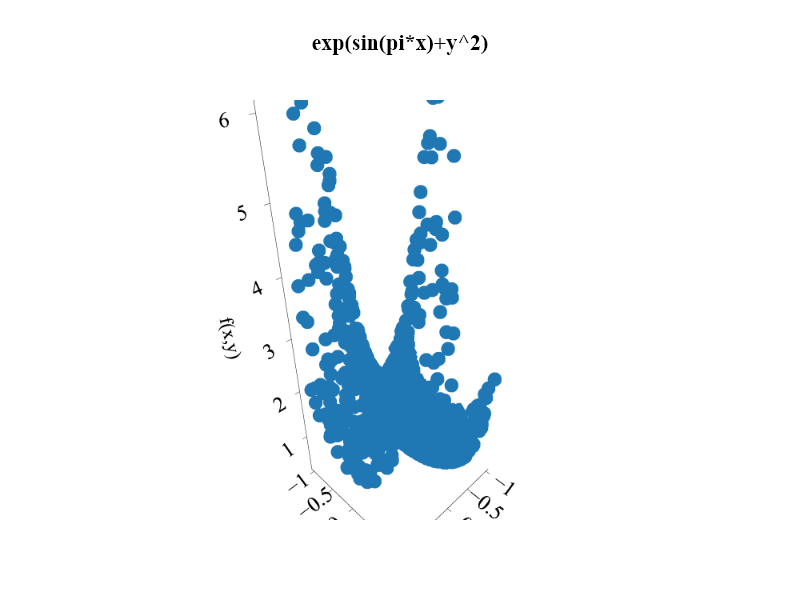

In [7]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, ranges=[-1, 1], train_num=1000, test_num=200)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=dataset['train_input'][:,0], y=dataset['train_input'][:,1], z=dataset['train_label'][:,0], mode='markers', name='train'))
fig.update_layout(template="simple_white", width=800, height=600, title="<b>exp(sin(pi*x)+y^2)<b>", title_x=0.5, scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="f(x,y)"), font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

train loss: 1.45e-02 | test loss: 1.47e-02 | reg: 1.28e+01 : 100%|██| 10/10 [00:02<00:00,  4.92it/s]


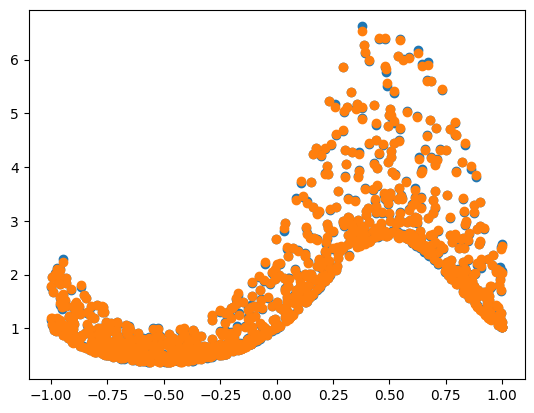

In [8]:
G = 5
k = 2
model = KAN(width=[2,5,1], grid=G, k=k)
dataset = create_dataset(f, n_var=2, ranges=[-1, 1], train_num=1000, test_num=200)
model.train(dataset, opt="LBFGS", steps=10, update_grid=True)
output = model(dataset['train_input'])
plt.scatter(dataset['train_input'][:,0].numpy(), dataset['train_label'].numpy())
plt.scatter(dataset['train_input'][:,0].numpy(), output.detach().numpy())
plt.show()

torch.Size([1000, 10])
torch.Size([1000, 5])


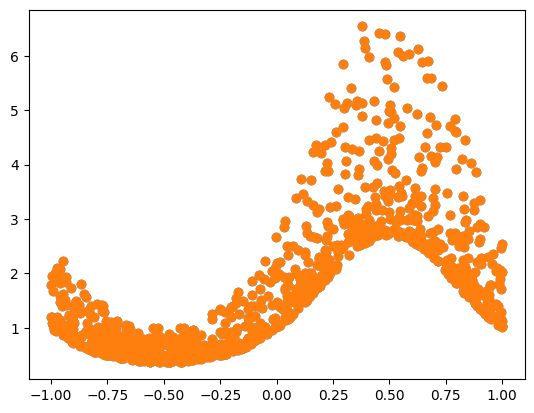

In [9]:
x = dataset['train_input']
for i in range(0, model.depth):
    x_transformed = torch.einsum('ij,k->ikj', x, torch.ones(model.act_fun[i].out_dim)).reshape(x.shape[0], model.act_fun[i].size).permute(1, 0)
    y = coef2curve(x_eval=x_transformed, grid=model.act_fun[i].grid, coef=model.act_fun[i].coef, k=k).permute(1, 0)
    print(y.shape)
    base = model.base_fun(x_transformed).permute(1, 0)
    output_scratch = model.act_fun[i].scale_base*base + model.act_fun[i].scale_sp.unsqueeze(dim=0) * y
    output_scratch = torch.sum(output_scratch.reshape(x.shape[0], model.act_fun[i].out_dim, model.act_fun[i].in_dim), dim=2)
    x = output_scratch+model.biases[i].weight[0]
output_scratch = x
x = dataset['train_input']
plt.scatter(x[:,0].numpy(), output_scratch.detach().numpy())
plt.scatter(x[:,0].numpy(), output.detach().numpy())
plt.show()

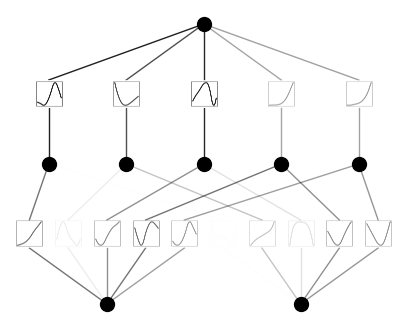

In [10]:
model.plot()

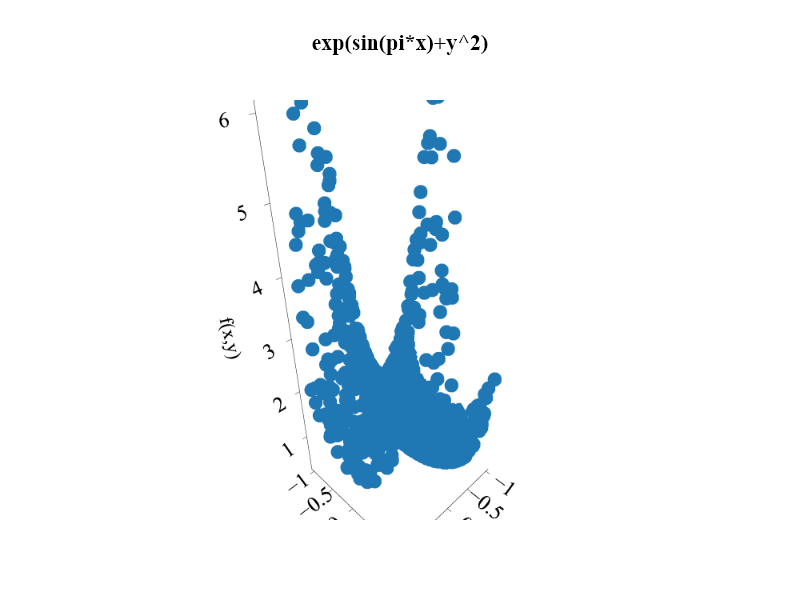

In [11]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, ranges=[-1, 1], train_num=1000, test_num=200)
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=dataset['train_input'][:,0], y=dataset['train_input'][:,1], z=dataset['train_label'][:,0], mode='markers', name='train'))
fig.update_layout(template="simple_white", width=800, height=600, title="<b>exp(sin(pi*x)+y^2)<b>", title_x=0.5, scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="f(x,y)"), font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

In [12]:
def train_rmse():
    return torch.sqrt(torch.mean((model(dataset['train_input'])-dataset['train_label'])**2))

def test_rmse():
    return torch.sqrt(torch.mean((model(dataset['test_input'])-dataset['test_label'])**2))

train_rmse_list = []
test_rmse_list = []
grid_points = [3, 5, 10, 20, 35, 50, 75, 100]
for G in grid_points:
    model = KAN(width=[2,5,1], grid=G, k=k)
    results = model.train(dataset, opt="LBFGS", metrics=(train_rmse, test_rmse), steps=50)
    train_rmse_list.append(results['train_rmse'][-1])
    test_rmse_list.append(results['test_rmse'][-1])

train loss: 1.04e-02 | test loss: 9.92e-03 | reg: 1.39e+01 : 100%|██| 50/50 [00:08<00:00,  5.79it/s]
train loss: 4.33e-03 | test loss: 5.00e-03 | reg: 1.26e+01 : 100%|██| 50/50 [00:10<00:00,  4.90it/s]
train loss: 5.95e-03 | test loss: 6.68e-03 | reg: 1.32e+01 : 100%|██| 50/50 [00:10<00:00,  4.56it/s]
train loss: 9.66e-04 | test loss: 1.33e-03 | reg: 1.25e+01 : 100%|██| 50/50 [00:11<00:00,  4.28it/s]
train loss: 8.15e-03 | test loss: 3.87e-02 | reg: 1.17e+01 : 100%|██| 50/50 [00:13<00:00,  3.85it/s]
train loss: 7.92e-03 | test loss: 9.05e-02 | reg: 1.22e+01 : 100%|██| 50/50 [00:13<00:00,  3.82it/s]
train loss: 3.14e-03 | test loss: 1.40e-01 | reg: 1.25e+01 : 100%|██| 50/50 [00:14<00:00,  3.53it/s]
train loss: 8.21e-04 | test loss: 7.66e-02 | reg: 1.10e+01 : 100%|██| 50/50 [00:14<00:00,  3.37it/s]


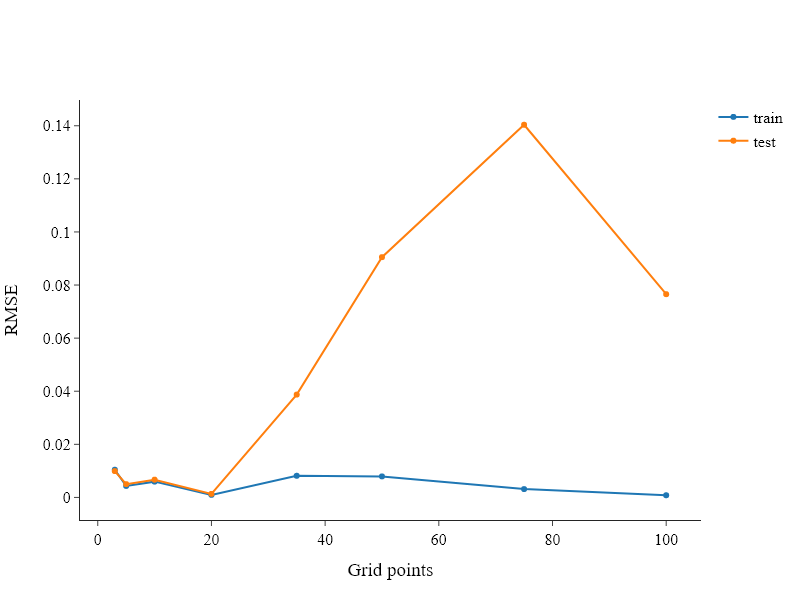

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=grid_points, y=train_rmse_list, mode='lines+markers', name='train'))
fig.add_trace(go.Scatter(x=grid_points, y=test_rmse_list, mode='lines+markers', name='test'))
fig.update_layout(template="simple_white", width=800, height=600, title_x=0.5, xaxis_title="Grid points", yaxis_title="RMSE", font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

train loss: 6.48e-03 | test loss: 8.12e-03 | reg: 1.33e+01 : 100%|██| 50/50 [00:11<00:00,  4.37it/s]


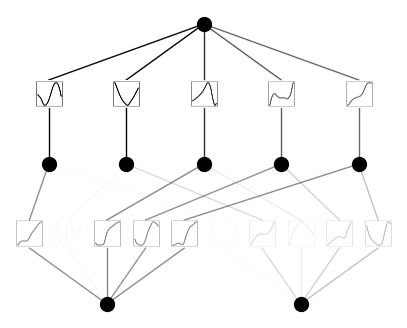

In [14]:
def train_rmse():
    return torch.sqrt(torch.mean((model(dataset['train_input'])-dataset['train_label'])**2))

def test_rmse():
    return torch.sqrt(torch.mean((model(dataset['test_input'])-dataset['test_label'])**2))

model = KAN(width=[2,5,1], grid=10, k=k)
results = model.train(dataset, opt="LBFGS", metrics=(train_rmse, test_rmse), steps=50)
model.plot()

train loss: 4.58e-01 | test loss: 4.34e-01 | reg: 2.56e+01 : 100%|██| 20/20 [00:04<00:00,  4.35it/s]


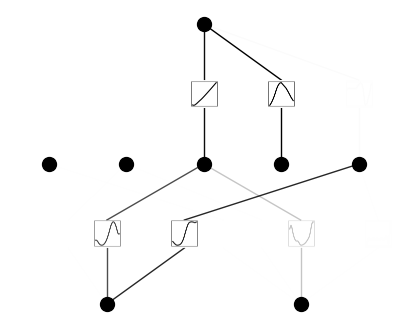

In [15]:
def train_rmse():
    return torch.sqrt(torch.mean((model(dataset['train_input'])-dataset['train_label'])**2))

def test_rmse():
    return torch.sqrt(torch.mean((model(dataset['test_input'])-dataset['test_label'])**2))

model = KAN(width=[2,5,1], grid=10, k=2, seed=17)
results = model.train(dataset, opt="LBFGS", metrics=(train_rmse, test_rmse), steps=20, lamb=0.1, lamb_entropy=10.)
model.plot()

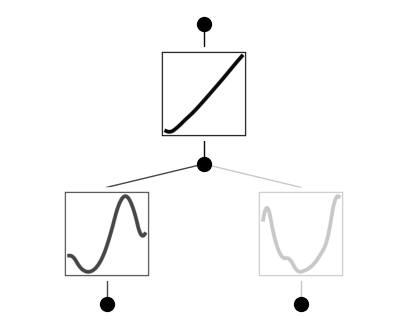

In [16]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [17]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9674336910247803
fixing (0,1,0) with x^2, r2=0.9637128710746765
fixing (1,0,0) with sin, r2=0.9994134306907654


In [18]:
model.train(dataset, opt="LBFGS", steps=50)

train loss: 1.02e-01 | test loss: 1.08e-01 | reg: 1.35e+01 : 100%|██| 50/50 [00:03<00:00, 13.81it/s]


{'train_loss': [array(0.35165393, dtype=float32),
  array(0.22977209, dtype=float32),
  array(0.22079822, dtype=float32),
  array(0.19833598, dtype=float32),
  array(0.17788395, dtype=float32),
  array(0.15782218, dtype=float32),
  array(0.12160157, dtype=float32),
  array(0.11356097, dtype=float32),
  array(0.11188746, dtype=float32),
  array(0.1080451, dtype=float32),
  array(0.10746122, dtype=float32),
  array(0.1065639, dtype=float32),
  array(0.10576278, dtype=float32),
  array(0.10448183, dtype=float32),
  array(0.10409324, dtype=float32),
  array(0.10334165, dtype=float32),
  array(0.10281651, dtype=float32),
  array(0.10262679, dtype=float32),
  array(0.10235549, dtype=float32),
  array(0.10225247, dtype=float32),
  array(0.10208842, dtype=float32),
  array(0.10184156, dtype=float32),
  array(0.101716, dtype=float32),
  array(0.10164338, dtype=float32),
  array(0.10163311, dtype=float32),
  array(0.10159604, dtype=float32),
  array(0.10156645, dtype=float32),
  array(0.10155839

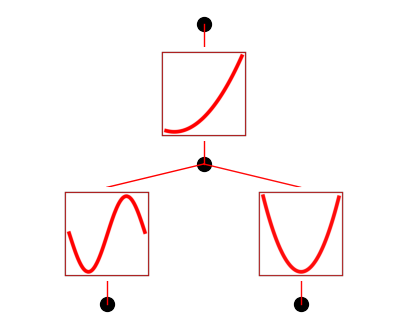

In [19]:
model.plot()

In [20]:
model.symbolic_formula()[0][0]

264.13*sin(0.08*x_2**2 - 0.08*sin(3.17*x_1 - 9.43) + 4.76) + 264.65